In [1]:
from ubibetter.models.compute_fraction  import compute_fraction
from ubibetter.utils.data.get_neigbours import get_neighbours
from ubibetter.models.compute_fraction import compute_fraction
from betbrain.manager.data_manager import data_manager

import pandas as pd
import numpy as np

from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
dm = data_manager(sport='Football')

In [3]:
data = dm.__get_data__()

In [4]:
campionato = dm.ubibetter.campionato.squeeze()
data = data.loc[campionato.isin(['E0', 'E1', 'E2', 'E3'])]

In [5]:
data.head()

odds              prob              \
                                        A     D     H     A     D     H   
MatchDate  HomeTeam AwayTeam   bkmr                                       
2000-08-12 Barnet   Shrewsbury IW    4.00  3.30  1.60  0.21  0.26  0.53   
                               SB    4.33  3.50  1.67  0.21  0.26  0.54   
                               WH    4.50  3.40  1.66  0.20  0.26  0.54   
           Barnsley Norwich    IW    3.80  3.20  1.65  0.22  0.26  0.51   
                               SB    4.33  3.25  1.73  0.21  0.28  0.52   

                                      book FTR  
                                                
MatchDate  HomeTeam AwayTeam   bkmr             
2000-08-12 Barnet   Shrewsbury IW    0.178   H  
                               SB    0.115   H  
                               WH    0.119   H  
           Barnsley Norwich    IW    0.182   H  
                               SB    0.117   H

In [18]:
train = data[data.index.get_level_values(0) < datetime(2018, 1, 1)]
test  = data[data.index.get_level_values(0) > datetime(2018, 1, 1)]

In [19]:
matrix = dm.ubibetter.get_matrix(train,[('prob', 'A'), ('prob', 'H'), 'book', 'FTR'])

In [20]:
matrix.head()

book                     -0.125  -0.017   0.000   0.001   0.002   0.003  \
(prob, A) (prob, H) FTR                                                   
0.03      0.86      A       0.0     0.0     0.0     0.0     0.0     0.0   
                    H       0.0     0.0     0.0     0.0     0.0     0.0   
          0.87      H       0.0     0.0     0.0     0.0     0.0     0.0   
          0.88      H       0.0     0.0     0.0     0.0     0.0     0.0   
          0.89      H       0.0     0.0     0.0     0.0     0.0     0.0   

book                      0.004   0.005   0.006   0.008  ...   0.289   0.293  \
(prob, A) (prob, H) FTR                                  ...                   
0.03      0.86      A       0.0     0.0     0.0     0.0  ...     0.0     0.0   
                    H       0.0     0.0     0.0     0.0  ...     0.0     0.0   
          0.87      H       0.0     0.0     0.0     0.0  ...     0.0     0.0   
          0.88      H       0.0     0.0     0.0     0.0  ...     0.0     0.0   
          0.89      H       0.0     0.0     0.0     0.0  ...     0.0     0.0   

book                      0.317   0.324   0.333   0.447   0.590   0.593  \
(prob, A) (prob, H) FTR                                                   
0.03      0.86      A       0.0     0.0     0.0     0.0     0.0     0.0   
                    H       0.0     0.0     0.0     0.0     0.0     0.0   
          0.87      H       0.0     0.0     0.0     0.0     0.0     0.0   
          0.88      H       0.0     0.0     0.0     0.0     0.0     0.0   
          0.89      H       0.0     0.0     0.0     0.0     0.0     0.0   

book                      0.620   0.622  
(prob, A) (prob, H) FTR                  
0.03      0.86      A       0.0     0.0  
                    H       0.0     0.0  
          0.87      H       0.0     0.0  
          0.88      H       0.0     0.0  
          0.89      H       0.0     0.0  

[5 rows x 215 columns]

In [22]:
test   = test.reset_index(level=3).set_index(['book','bkmr'], append=True)
vicini = test.prob[['A', 'H']].apply(get_neighbours, axis=1).rename('NN').to_frame()


# Togliere iloc alla fine
probs  = vicini.apply(dm.ubibetter.__compute_probs__, axis=1, args=[matrix])
probs.columns = pd.MultiIndex.from_tuples([('KLFY', c) for c in probs.columns])

In [23]:
probs.head()

KLFY                    
                                                A         D         H
MatchDate  HomeTeam AwayTeam book  bkmr                              
2018-01-02 Fulham   Ipswich  0.069 B365  0.189573  0.232227  0.578199
                             0.072 BW    0.000000  0.277778  0.722222
                             0.079 IW    0.250000  0.500000  0.250000
                             0.071 LB    0.102564  0.282051  0.615385
                             0.025 PS    0.175676  0.229730  0.594595

In [24]:
aux = pd.concat([test.odds.stack().rename('odd'), probs.KLFY.stack().rename('prob')], axis=1, join='inner')
aux = aux.reset_index(level=5).merge(test['FTR'], right_index=True, left_index=True)
aux = aux.reset_index(level=3, drop=True)
aux = aux.rename(columns={'level_5':'level_4'})

In [25]:
aux.head(6)

level_4   odd      prob FTR
MatchDate  HomeTeam AwayTeam bkmr                            
2018-01-02 Fulham   Ipswich  PS         H  1.65  0.594595   H
                             PS         D  4.22  0.229730   H
                             PS         A  5.51  0.175676   H
                             VC         D  4.30  0.000000   H
                             VC         H  1.60  1.000000   H
                             VC         A  5.20  0.000000   H

In [26]:
frac = aux.groupby(level=[0,1,2,3]).apply(compute_fraction).rename('frac').to_frame()
aux  = pd.concat([aux.set_index('level_4', append=True), frac.round(4)], axis=1).reset_index(level=4)

In [27]:
def perform_simulation(x):
    if x['level_4'] == x['FTR']:
        return (x['odd'] - 1) * x['frac']
    elif x['level_4'] != x['FTR']:
        return -x['frac']

In [28]:
aux['margin'] = aux.apply(perform_simulation, axis=1)

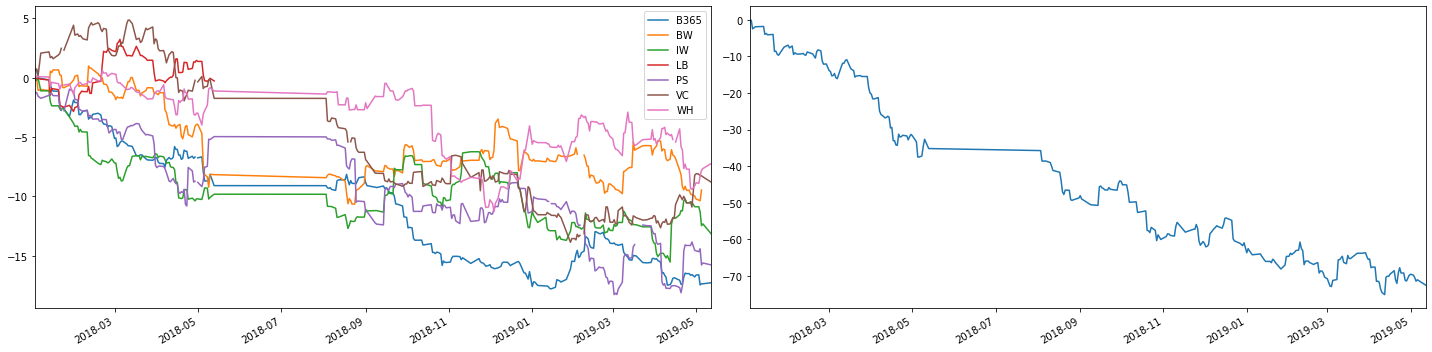

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
aux.margin.groupby(level=[0,3]).sum().unstack().cumsum().plot(ax=ax[0])
aux.margin.groupby(level=[0]).sum().cumsum().plot(ax=ax[1])
plt.tight_layout()